<a href="https://colab.research.google.com/github/prathammehta16/ConsumerComplaintsClassification_AutoML/blob/main/Consumer_Complaints_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-72).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
openjdk version "11.0.17" 2022-10-18
OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04)
OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)


In [ ]:
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.38.0.4-py2.py3-none-any.whl size=177628739 sha256=b678b601e8d6d488e7d2b2ded4f81e9656f20159124153dc5cafee0dd7abf1bd
  Stored in directory: /root/.cache/pip/wheels/6b/1d/65/39927b5984bde22f615b4c6e9a8ee98ea4abf1acb5926623ff
Successfully built h2o


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from textblob import TextBlob
from textblob import Word
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpsvq79dgz
  JVM stdout: /tmp/tmpsvq79dgz/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpsvq79dgz/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,"28 days, 18 hours and 38 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_ea7qxa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from io import StringIO
import os
import string
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english') 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip /content/drive/MyDrive/ML_Projects/consumer_compliants.zip

Archive:  /content/drive/MyDrive/ML_Projects/consumer_compliants.zip
  inflating: consumer_compliants.csv  


In [ ]:
df = pd.read_csv('consumer_compliants.csv')

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704


In [ ]:
df.tail()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566
57452,1/16/2020,Debt collection,Auto debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,I spoken with them several times in a year. An...,None,Exeter Finance Corp.,SC,None,None,Consent provided,Web,1/16/2020,Closed with explanation,Yes,NaN,3498524


In [ ]:
df.dtypes

Date received                    object
Product                          object
Sub-product                      object
Issue                            object
Sub-issue                        object
Consumer complaint narrative     object
Company public response          object
Company                          object
State                            object
ZIP code                         object
Tags                             object
Consumer consent provided?       object
Submitted via                    object
Date sent to company             object
Company response to consumer     object
Timely response?                 object
Consumer disputed?              float64
Complaint ID                      int64
dtype: object

In [ ]:
df.shape

(57453, 18)

In [ ]:
df.describe(include="all")

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,57453,0.0,5.745300e+04
unique,354,6,32,44,160,55390,11,2197,60,2874,4,1,1,359,5,2,NaN,NaN
top,4/23/2020,Debt collection,General-purpose credit card or charge card,Attempts to collect debt not owed,None,I am a victim of identity theft and this debt ...,None,"CITIBANK, N.A.",CA,None,None,Consent provided,Web,5/21/2020,Closed with explanation,Yes,NaN,NaN
freq,293,21772,9968,10326,10009,318,30661,3226,7938,13708,45951,57453,57453,300,47819,55987,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.498561e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.091834e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.315180e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.405102e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.491446e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.588478e+06


In [ ]:
df.isnull().sum()/df.shape[0]*100

Date received                     0.0
Product                           0.0
Sub-product                       0.0
Issue                             0.0
Sub-issue                         0.0
Consumer complaint narrative      0.0
Company public response           0.0
Company                           0.0
State                             0.0
ZIP code                          0.0
Tags                              0.0
Consumer consent provided?        0.0
Submitted via                     0.0
Date sent to company              0.0
Company response to consumer      0.0
Timely response?                  0.0
Consumer disputed?              100.0
Complaint ID                      0.0
dtype: float64

In [ ]:
df1 = df[['Complaint ID','Date received','Product','Issue','Company','State','Submitted via','Company response to consumer','Timely response?','Consumer complaint narrative']]

In [ ]:
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

[Text(0, 0, 'Vehicle loan or lease'),
 Text(0, 0, 'Debt collection'),
 Text(0, 0, 'Checking or savings account'),
 Text(0, 0, 'Mortgage'),
 Text(0, 0, 'Credit card or prepaid card'),
 Text(0, 0, 'Student loan')]

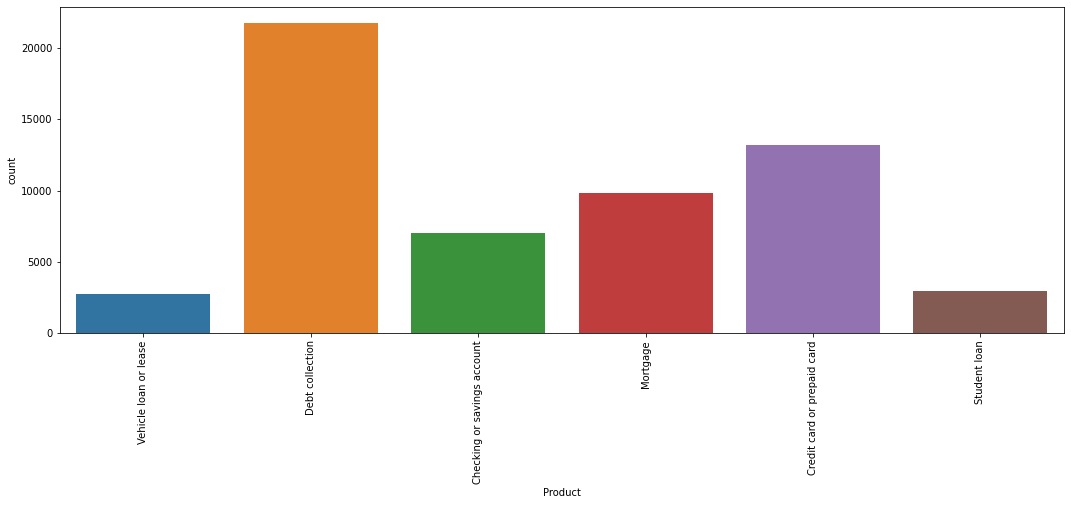

In [ ]:
fig,ax = plt.subplots(figsize=(18,6))
sns.countplot(x='Product', data=df1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
#df['Product'].value_counts().plot(kind='bar')

In [ ]:
df1['Company'].value_counts()

CITIBANK, N.A.                                                    3226
CAPITAL ONE FINANCIAL CORPORATION                                 2711
BANK OF AMERICA, NATIONAL ASSOCIATION                             2580
JPMORGAN CHASE & CO.                                              2409
WELLS FARGO & COMPANY                                             2001
                                                                  ... 
Time Investment Company, Inc.                                        1
Automotive Services Finance, Inc.                                    1
Foxstar Energy Resources LLC DBA Federal Student Loans Council       1
Uplift, Inc                                                          1
Keystone Credit Services LLC                                         1
Name: Company, Length: 2197, dtype: int64

In [ ]:
#pd.crosstab(df1['Product'], df1['Consumer disputed?']).plot(kind='bar')

In [ ]:
df1['Date received'] = pd.to_datetime(df1['Date received'])

In [ ]:
df1['Date received'].min(),df1['Date received'].max()

(Timestamp('2019-07-24 00:00:00'), Timestamp('2020-07-11 00:00:00'))

In [ ]:
df1['month'] = df1['Date received'].dt.month

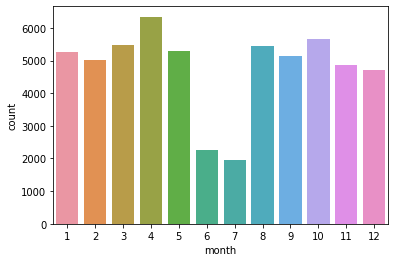

In [ ]:
sns.countplot(x='month',data=df1)

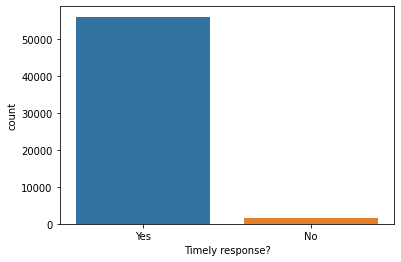

In [ ]:
sns.countplot(x='Timely response?',data=df1)

In [ ]:
df1['Consumer complaint narrative'] =df1['Consumer complaint narrative'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))

In [ ]:
df1['Consumer complaint narrative'].sample(2)

34611    i have repeatedly disputed the following charg...
46693    i live in ny which is the hardest hit with cov...
Name: Consumer complaint narrative, dtype: object

In [ ]:
df1['Consumer complaint narrative'] =df1['Consumer complaint narrative'].str.replace(r'[^\w\s]',"")

In [ ]:
df1['Consumer complaint narrative'].sample(2)

17613    xxxx xxxx xxxx xxxx xxxx xxxx xxxx va xxxx wit...
31701    this is my second complaint regarding this iss...
Name: Consumer complaint narrative, dtype: object

In [ ]:
#Below, we used three normalizazion dictionaries from these links :
#http://www.hlt.utdallas.edu/~yangl/data/Text_Norm_Data_Release_Fei_Liu/
#http://people.eng.unimelb.edu.au/tbaldwin/etc/emnlp2012-lexnorm.tgz
#http://luululu.com/tweet/typo-corpus-r1.txt
dico = {}
dico1 = open('doc1.txt', 'rb')
for word in dico1:
    word = word.decode('utf8')
    word = word.split()
    dico[word[1]] = word[3]
dico1.close()
dico2 = open('doc2.txt', 'rb')
for word in dico2:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico2.close()
dico3 = open('doc3.txt', 'rb')
for word in dico3:
    word = word.decode('utf8')
    word = word.split()
    dico[word[0]] = word[1]
dico3.close()

In [ ]:
def txt_std(words):
    list_words = words.split()
    for i in range(len(list_words)):
        if list_words[i] in dico.keys():
            list_words[i] = dico[list_words[i]]
    return ' '.join(list_words)

In [ ]:
df1['Consumer complaint narrative'] = df1['Consumer complaint narrative'].apply(txt_std)

In [ ]:
df1['Consumer complaint narrative'].head()

0    this auto loan was opened on xxxx2020 in xxxx ...
1    in xxxx of 2019 i noticed a debt for 62000 on ...
2    as stated from capital one xxxx xxxxxxxx and x...
3    please see cfpb case xxxx capital one in the l...
4    this debt was incurred due to medical malpract...
Name: Consumer complaint narrative, dtype: object

In [ ]:
df1['Consumer complaint narrative'] = df1['Consumer complaint narrative'].str.replace(r"xx+\s","")

In [ ]:
df1['Consumer complaint narrative'].head(1)

0    this auto loan was opened on xxxx2020 in nc wi...
Name: Consumer complaint narrative, dtype: object

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df1['Consumer complaint narrative'] =df1['Consumer complaint narrative'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))

In [ ]:
df1['Consumer complaint narrative'].head(1)

0    auto loan opened xxxx2020 nc name never north ...
Name: Consumer complaint narrative, dtype: object

In [ ]:
#from textblob import TextBlob
#df1['Consumer complaint narrative'] =df1['Consumer complaint narrative'].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
"""
import multiprocessing
from textblob import TextBlob

def correct_text(text):
    return str(TextBlob(text).correct())

df1['Consumer complaint narrative'] = df1['Consumer complaint narrative'].apply(correct_text)

# Creating a pool of worker processes to apply the function
pool = multiprocessing.Pool()
df1['Consumer complaint narrative'] = pool.map(correct_text, df1['Consumer complaint narrative'])
"""

"\nimport multiprocessing\nfrom textblob import TextBlob\n\ndef correct_text(text):\n    return str(TextBlob(text).correct())\n\ndf1['Consumer complaint narrative'] = df1['Consumer complaint narrative'].apply(correct_text)\n\n# Creating a pool of worker processes to apply the function\npool = multiprocessing.Pool()\ndf1['Consumer complaint narrative'] = pool.map(correct_text, df1['Consumer complaint narrative'])\n"

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from textblob import Word

df1['Consumer complaint narrative'] =df1['Consumer complaint narrative'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))

In [ ]:
df1['Consumer complaint narrative'].head(1)

0    auto loan opened xxxx2020 nc name never north ...
Name: Consumer complaint narrative, dtype: object

In [ ]:
"""
for product_name in df1['Product'].unique():
  print(product_name)
  all_words = ' '.join([text for text in df1.loc[df1['Product'].str.contains(product_name), 'Consumer complaint narrative']])
  from wordcloud import WordCloud
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()
"""

'\nfor product_name in df1[\'Product\'].unique():\n  print(product_name)\n  all_words = \' \'.join([text for text in df1.loc[df1[\'Product\'].str.contains(product_name), \'Consumer complaint narrative\']])\n  from wordcloud import WordCloud\n  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)\n\n  plt.figure(figsize=(10, 7))\n  plt.imshow(wordcloud, interpolation="bilinear")\n  plt.axis(\'off\')\n  plt.show()\n'

In [ ]:
#from sklearn.model_selection import train_test_split
#train_x, test_x, train_y, test_y = train_test_split(df1['Consumer complaint narrative'], df1['Product'],stratify=df1['Product'], test_size=0.25)

In [ ]:
"""
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
train_y = enc.fit_transform(train_y)
test_y = enc.fit_transform(test_y)
"""

'\nfrom sklearn import preprocessing\nenc = preprocessing.LabelEncoder()\ntrain_y = enc.fit_transform(train_y)\ntest_y = enc.fit_transform(test_y)\n'

In [ ]:
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [ ]:
"""
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df1['Consumer complaint narrative'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)
"""

"\ntfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\\w{1,}', max_features=5000)\ntfidf_vect.fit(df1['Consumer complaint narrative'])\nxtrain_tfidf =  tfidf_vect.transform(train_x)\nxtest_tfidf =  tfidf_vect.transform(test_x)\n"

In [ ]:
#tfidf_vect.get_feature_names()

In [ ]:
complaints_df=df1[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})

In [ ]:
pd.set_option('display.max_colwidth', -1)
complaints_df

,complaints,Product,Company
0,auto loan opened xxxx2020 nc name never north carolina never resident filed dispute twice credit bureau time claimed accurate loan want aware today tried contact multiple time never gotten live person drive never owned car knowledge account checked noticed live tried twice dispute additionally never received bill information account last resort trying remove fraudulent loan account,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,2019 noticed debt 62000 credit believed mine thought speedy cash bought one old debt sold contacted several attempt giving full name nothing came system gave social rep said account popped tell account someone else name continued let make payment payment 12000 confirmation numberafter realizing account called back get money back inform mistake told needed mail fcc report dispute letter get money back completed called said transfered account back speedy cash fraud review would need contact contacting told get money back issue representative played blind obvious fraud let innocent person make payment someone else debt want money back,Debt collection,CURO Intermediate Holdings
2,stated capital one 2018 wife went several car dealership request car loan get used car however according credit requirement unfortunately credit score insufficient car loan approval time seemed though pulled credit report multiple time,Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,please see cfpb case capital one letter provided attached case response said fund reversed sent back received fund staff also staff accountholder business looked return money 65000 find nothing capital one need document actually prove returned fund stated letter capital one must provide electronic information return made way document paper check sent back live left 3 message problem person signed letter capital one received callback summary capital one said returned money continue claim need prove,Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,debt incurred due medical malpractice thanks asked doctor turn claim malpractice insurance company cost thousand dollar still trying collect damage doctor never responded turned collection merchant professional collection bureau sent letter describing exactly issue instead contacting verifying debt start reporting debt credit reporting agency never verified debt like asked never stopped reported specifically told due circumstance,Debt collection,"Merchants and Professional Bureau, Inc."
...,...,...,...
57448,attempting make payment toward student loan nelnet website today xxxx20 nelnet allow post payment sooner xxxx20 time payment post 23 day additional interest accrued payment apply interest due today day attempting pay understanding could make payment time appear true fund available bank account today regardless whether nelnet collect weekend penalized submitted complaint deceptive practice nelnet yet resolved issue identified complaint contacted said would response believe new issue one deceptive practice company cause financial harm borrower,Student loan,"Nelnet, Inc."
57449,received letter 48000 original creditor contact past statute limitation insurance company recoupment per arizona law debt collection illegal phantom debt additionally phoning office excessively,Debt collection,"The Receivable Management Services LLC, New York, NY Branch"
57450,entire time 10 year xxxx2020 make blood boil called lied told provide checking account information phone order turn cell phone back called 30000 added bill scan scan scan told call office president write im three thousand time last letter mailed xxxx2020 two collection agency later chose leave every time called supervisor would threaten recorded line need peace mind good heart beat inside due stress taking money 4 10 year,Debt collection,"Convergent Resources, Inc."
57451,customer well fargo bank recently money withdrawn couple occasion without permission consent pay timeshare account never used anyone co

In [ ]:
#target={'Credit reporting, credit repair services, or other personal consumer reports':0, 'Credit card or prepaid card':1, 'Debt collection':2, 'Checking or savings account':3, 'Mortgage':4, 'Vehicle loan or lease':5, 'Student loan':6,
#        'Money transfer, virtual currency, or money service':7, 'Payday loan, title loan, or personal loan':8, 'Credit reporting':9, 'Credit card':10, 'Bank account or service':11, 'Payday loan':12, 'Consumer Loan':13, 'Money transfers':14, 'Prepaid card':15, 'Other financial service':16, 'Virtual currency':17}

In [ ]:
target={'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}

In [ ]:
complaints_df['target']=complaints_df['Product'].map(target)

In [ ]:
complaints_df

,complaints,Product,Company,target
0,auto loan opened xxxx2020 nc name never north carolina never resident filed dispute twice credit bureau time claimed accurate loan want aware today tried contact multiple time never gotten live person drive never owned car knowledge account checked noticed live tried twice dispute additionally never received bill information account last resort trying remove fraudulent loan account,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION,5
1,2019 noticed debt 62000 credit believed mine thought speedy cash bought one old debt sold contacted several attempt giving full name nothing came system gave social rep said account popped tell account someone else name continued let make payment payment 12000 confirmation numberafter realizing account called back get money back inform mistake told needed mail fcc report dispute letter get money back completed called said transfered account back speedy cash fraud review would need contact contacting told get money back issue representative played blind obvious fraud let innocent person make payment someone else debt want money back,Debt collection,CURO Intermediate Holdings,0
2,stated capital one 2018 wife went several car dealership request car loan get used car however according credit requirement unfortunately credit score insufficient car loan approval time seemed though pulled credit report multiple time,Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION,5
3,please see cfpb case capital one letter provided attached case response said fund reversed sent back received fund staff also staff accountholder business looked return money 65000 find nothing capital one need document actually prove returned fund stated letter capital one must provide electronic information return made way document paper check sent back live left 3 message problem person signed letter capital one received callback summary capital one said returned money continue claim need prove,Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION,3
4,debt incurred due medical malpractice thanks asked doctor turn claim malpractice insurance company cost thousand dollar still trying collect damage doctor never responded turned collection merchant professional collection bureau sent letter describing exactly issue instead contacting verifying debt start reporting debt credit reporting agency never verified debt like asked never stopped reported specifically told due circumstance,Debt collection,"Merchants and Professional Bureau, Inc.",0
...,...,...,...,...
57448,attempting make payment toward student loan nelnet website today xxxx20 nelnet allow post payment sooner xxxx20 time payment post 23 day additional interest accrued payment apply interest due today day attempting pay understanding could make payment time appear true fund available bank account today regardless whether nelnet collect weekend penalized submitted complaint deceptive practice nelnet yet resolved issue identified complaint contacted said would response believe new issue one deceptive practice company cause financial harm borrower,Student loan,"Nelnet, Inc.",4
57449,received letter 48000 original creditor contact past statute limitation insurance company recoupment per arizona law debt collection illegal phantom debt additionally phoning office excessively,Debt collection,"The Receivable Management Services LLC, New York, NY Branch",0
57450,entire time 10 year xxxx2020 make blood boil called lied told provide checking account information phone order turn cell phone back called 30000 added bill scan scan scan told call office president write im three thousand time last letter mailed xxxx2020 two collection agency later chose leave every time called supervisor would threaten recorded line need peace mind good heart beat inside due stress taking money 4 10 year,Debt collection,"Convergent Resources, Inc.",0
57451,customer well fargo bank recently money withdrawn couple occasion without permission consent pay timeshare a

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(complaints_df, test_size=0.2, random_state=111)

In [ ]:
vectorizer_tf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_df=0.75,lowercase=False,max_features=1000,ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.complaints)

In [ ]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06161378, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
vectorizer_tf.get_feature_names()

['000',
 '1',
 '10',
 '100',
 '10000',
 '100000',
 '12',
 '15',
 '15 use',
 '2',
 '20',
 '20000',
 '2019',
 '3',
 '3 month',
 '30',
 '30 day',
 '30000',
 '4',
 '5',
 '50000',
 '6',
 '6 month',
 '60',
 '60 day',
 '7',
 '8',
 '90',
 '90 day',
 'ability',
 'able',
 'accept',
 'accepted',
 'access',
 'accordance',
 'according',
 'account',
 'account closed',
 'account credit',
 'account number',
 'account opened',
 'accurate',
 'act',
 'action',
 'activity',
 'actual',
 'actually',
 'add',
 'added',
 'addition',
 'additional',
 'address',
 'advance',
 'advantage',
 'advised',
 'affidavit',
 'afford',
 'agency',
 'agent',
 'ago',
 'agreed',
 'agreement',
 'alert',
 'alleged',
 'alleged debt',
 'allow',
 'allowed',
 'ally',
 'almost',
 'along',
 'already',
 'also',
 'although',
 'always',
 'america',
 'america express',
 'amex',
 'amount',
 'amount due',
 'andor',
 'annual',
 'another',
 'answer',
 'answered',
 'anyone',
 'anything',
 'apartment',
 'apparently',
 'appears',
 'application',
 

In [ ]:
test_vectors = vectorizer_tf.transform(X_test.complaints)

In [ ]:
X_train.shape

(45962, 4)

In [ ]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

,000,1,10,100,10000,100000,12,15,15 use,2,...,xxxx19,xxxx20,xxxx2018,xxxx2019,xxxx2020,year,year ago,yes,yet,target
0,0.0,0.000000,0.000000,0.038832,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,3
1,0.0,0.061614,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.264951,0.000000,0.045238,0.0,0.0,0.000000,0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0
3,0.0,0.000000,0.051499,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.091373,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.060635,1
45958,0.0,0.000000,0.000000,0.000000,0.000000,0.146001,0.0,0.135247,0.0,0.092546,...,0.0,0.0,0.0,0.000000,0.108913,0.000000,0.0,0.0,0.000000,2
45959,0.0,0.000000,0.000000,0.000000,0.467666,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.097361,0.000000,0.083118,0.0,0.0,0.000000,1
45960,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1


In [ ]:

test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df

,000,1,10,100,10000,100000,12,15,15 use,2,...,xxxx19,xxxx20,xxxx2018,xxxx2019,xxxx2020,year,year ago,yes,yet,target
0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.084466,0.000000,0.000000,0.00000,0.0,0.000000,3
1,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,2
2,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,1
3,0.128988,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.094783,0.00000,0.0,0.000000,4
4,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.074976,...,0.0,0.0,0.0,0.000000,0.088236,0.130675,0.11516,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.000000,0.0,0.0,0.0,0.12996,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.034647,0.00000,0.0,0.000000,1
11487,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,4
11488,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.139090,0.000000,0.000000,0.00000,0.0,0.000000,2
11489,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.090163,0.00000,0.0,0.061825,0


In [ ]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
h2o_train_df.types

{'000': 'real',
 '1': 'real',
 '10': 'real',
 '100': 'real',
 '10000': 'real',
 '100000': 'real',
 '12': 'real',
 '15': 'real',
 '15 use': 'real',
 '2': 'real',
 '20': 'real',
 '20000': 'real',
 '2019': 'real',
 '3': 'real',
 '3 month': 'real',
 '30': 'real',
 '30 day': 'real',
 '30000': 'real',
 '4': 'real',
 '5': 'real',
 '50000': 'real',
 '6': 'real',
 '6 month': 'real',
 '60': 'real',
 '60 day': 'real',
 '7': 'real',
 '8': 'real',
 '90': 'real',
 '90 day': 'real',
 'ability': 'real',
 'able': 'real',
 'accept': 'real',
 'accepted': 'real',
 'access': 'real',
 'accordance': 'real',
 'according': 'real',
 'account': 'real',
 'account closed': 'real',
 'account credit': 'real',
 'account number': 'real',
 'account opened': 'real',
 'accurate': 'real',
 'act': 'real',
 'action': 'real',
 'activity': 'real',
 'actual': 'real',
 'actually': 'real',
 'add': 'real',
 'added': 'real',
 'addition': 'real',
 'additional': 'real',
 'address': 'real',
 'advance': 'real',
 'advantage': 'real',
 

In [ ]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

In [ ]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [ ]:
x=vectorizer_tf.get_feature_names()
y='target'

In [ ]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
12:24:52.492: Project: AutoML_1_20230203_122452
12:24:52.493: Cross-validation disabled by user: no fold column nor nfolds > 1.
12:24:52.518: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
12:24:52.518: Build control seed: 10
12:24:52.520: training frame: Frame key: AutoML_1_20230203_122452_training_py_1_sid_9258    cols: 1001    rows: 45962  chunks: 54    size: 38456636  checksum: 1615946593113558623
12:24:52.526: validation frame: Frame key: py_2_sid_9258    cols: 1001    rows: 11491  chunks: 14    size: 9643675  checksum: 809930846812084552
12:24:52.528: leaderboard frame: Frame key: py_2_sid_9258    cols: 1001    rows: 11491  chunks: 14    size: 9643675  checksum: 809930846812084552
12:24:52.528: blending frame: NULL
12:24:52.528: response column: target
12:24:52.528: fold column: null
12:24:52.528: weights column: null
12:24:52.619: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), gr

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20230203_122452


Model Summary: 
    number_of_trees
--  -----------------
    80

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.03651592652137326
RMSE: 0.1910914088110014
LogLoss: 0.1321573815024984
Mean Per-Class Error: 0.046925100327366825
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0      1      2     3     4     5     Error      Rate
-----  -----  ----  ----  ----  ----  ---------  --------------
17096  197    66    49    32    37    0.0218001  381 / 17,477
299    10185  13    93    8     12    0.0400566  425 / 10,610
87     51     7612  19    9     6     0.0220966  172 / 7,784
87     113    6     5332  0     4     0.0378925  210 / 5,542
79     50     11    3     2193  3     0.0624198  146 / 2,339
126    62     13    6     8     1995  0.0972851  215 / 2,210
17774  10658  7721  5502  2250  2057  0.0337018  1,549 / 45,962

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.966298
2    0.991863
3    0.997085
4    0.999217
5    0.999848
6    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09255694538171537
RMSE: 0.3042317297418456
LogLoss: 0.32400495655222433
Mean Per-Class Error: 0.14779001085650242
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     3     4    5    Error      Rate
----  ----  ----  ----  ---  ---  ---------  --------------
4000  130   53    28    39   45   0.0686845  295 / 4,295
158   2292  25    95    3    10   0.11266    291 / 2,583
59    23    1876  22    17   18   0.0689826  139 / 2,015
45    129   21    1259  2    5    0.138261   202 / 1,461
61    23    23    1     489  14   0.199673   122 / 611
74    34    31    8     10   369  0.298479   157 / 526
4397  2631  2029  1413  560  461  0.104952   1,206 / 11,491

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.895048
2    0.965538
3    0.985641
4    0.993473
5    0.998085
6    1

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_logloss    training_classification_error    training_auc    training_pr_auc    validation_rmse    validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
--  -------------------  ----------------  -----------------  ---------------  ------------------  -------------------------------  --------------  -----------------  -----------------  --------------------  ---------------------------------  ----------------  -------------------
    2023-02-03 12:24:53  1.036 sec         0                  0.833333         1.79176             0.830643                         nan             nan                0.833333           1.79176               0.824645                           nan               nan
    2023-02-03 12:25:05  12.143 sec        5                  0.448724         0.60988             0.117597                         nan             nan                0.46531            0.650768              0.140371                           nan               nan
    2023-02-03 12:25:10  18.070 sec        10                 0.342772         0.38959             0.101432                         nan             nan                0.374715           0.457598              0.1

In [ ]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_1_20230203_122452,0.14779,0.324005,0.304232,0.0925569
XGBoost_2_AutoML_1_20230203_122452,0.148676,0.324334,0.304343,0.0926247
GBM_1_AutoML_1_20230203_122452,0.148705,0.363978,0.324604,0.105368
XGBoost_3_AutoML_1_20230203_122452,0.149342,0.321422,0.306869,0.0941685
GBM_4_AutoML_1_20230203_122452,0.157565,0.389327,0.338218,0.114391
GBM_2_AutoML_1_20230203_122452,0.158668,0.38654,0.337708,0.114047
GBM_3_AutoML_1_20230203_122452,0.159194,0.386726,0.337206,0.113708
GLM_1_AutoML_1_20230203_122452,0.16172,0.359081,0.324395,0.105232
XRT_1_AutoML_1_20230203_122452,0.273653,0.580517,0.43813,0.191958
DRF_1_AutoML_1_20230203_122452,0.280574,0.582855,0.439318,0.193


In [ ]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [ ]:
aml.leader.model_performance(h2o_test_df)

ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09255694538171537
RMSE: 0.3042317297418456
LogLoss: 0.32400495655222433
Mean Per-Class Error: 0.14779001085650242
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     3     4    5    Error      Rate
----  ----  ----  ----  ---  ---  ---------  --------------
4000  130   53    28    39   45   0.0686845  295 / 4,295
158   2292  25    95    3    10   0.11266    291 / 2,583
59    23    1876  22    17   18   0.0689826  139 / 2,015
45    129   21    1259  2    5    0.138261   202 / 1,461
61    23    23    1     489  14   0.199673   122 / 611
74    34    31    8     10   369  0.298479   157 / 526
4397  2631  2029  1413  560  461  0.104952   1,206 / 11,491

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.895048
2    0.965538
3    0.985641
4    0.993473
5    0.998085
6    1

In [ ]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [ ]:
out

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20230203_122452


Model Summary: 
    number_of_trees
--  -----------------
    80

ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.03651592652137326
RMSE: 0.1910914088110014
LogLoss: 0.1321573815024984
Mean Per-Class Error: 0.046925100327366825
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0      1      2     3     4     5     Error      Rate
-----  -----  ----  ----  ----  ----  ---------  --------------
17096  197    66    49    32    37    0.0218001  381 / 17,477
299    10185  13    93    8     12    0.0400566  425 / 10,610
87     51     7612  19    9     6     0.0220966  172 / 7,784
87     113    6     5332  0     4     0.0378925  210 / 5,542
79     50     11    3     2193  3     0.0624198  146 / 2,339
126    62     13    6     8     1995  0.0972851  215 / 2,210
17774  10658  7721  5502  2250  2057  0.0337018  1,549 / 45,962

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.966298
2    0.991863
3    0.997085
4    0.999217
5    0.999848
6    1

ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09255694538171537
RMSE: 0.3042317297418456
LogLoss: 0.32400495655222433
Mean Per-Class Error: 0.14779001085650242
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0     1     2     3     4    5    Error      Rate
----  ----  ----  ----  ---  ---  ---------  --------------
4000  130   53    28    39   45   0.0686845  295 / 4,295
158   2292  25    95    3    10   0.11266    291 / 2,583
59    23    1876  22    17   18   0.0689826  139 / 2,015
45    129   21    1259  2    5    0.138261   202 / 1,461
61    23    23    1     489  14   0.199673   122 / 611
74    34    31    8     10   369  0.298479   157 / 526
4397  2631  2029  1413  560  461  0.104952   1,206 / 11,491

Top-6 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.895048
2    0.965538
3    0.985641
4    0.993473
5    0.998085
6    1

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_logloss    training_classification_error    training_auc    training_pr_auc    validation_rmse    validation_logloss    validation_classification_error    validation_auc    validation_pr_auc
--  -------------------  ----------------  -----------------  ---------------  ------------------  -------------------------------  --------------  -----------------  -----------------  --------------------  ---------------------------------  ----------------  -------------------
    2023-02-03 12:24:53  1.036 sec         0                  0.833333         1.79176             0.830643                         nan             nan                0.833333           1.79176               0.824645                           nan               nan
    2023-02-03 12:25:05  12.143 sec        5                  0.448724         0.60988             0.117597                         nan             nan                0.46531            0.650768              0.140371                           nan               nan
    2023-02-03 12:25:10  18.070 sec        10                 0.342772         0.38959             0.101432                         nan             nan                0.374715           0.457598              0.1

In [ ]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'updater': 'grow_gpu_hist',
  'eta': 0.3,
  'objective': 'multi:softprob',
  'min_child_weight': 10.0,
  'nthread': 2,
  'seed': 10,
  'num_class': 6,
  'max_bin': 256,
  'max_depth': 15,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'gpu_id': 0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 10000,
  'subsample': 0.6,
  'max_delta_step': 0.0,
  'colsample_bylevel': 0.8},
 10000)

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [ ]:
xgb_clf.fit(train_vectors, X_train['target'])

[13:51:55] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(learning_rate=0.05, max_depth=6, objective='multi:softprob',
              random_state=10, updater='grow_gpu')

In [ ]:
predictions = xgb_clf.predict(test_vectors)

In [ ]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[3933  163   63   43   40   53]
 [ 280 2173   13  102    2   13]
 [  97   28 1833   22   27    8]
 [  92  134   21 1206    2    6]
 [  82   26   26    2  465   10]
 [  85   38   24   10   16  353]]


In [ ]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      4295
           1       0.85      0.84      0.84      2583
           2       0.93      0.91      0.92      2015
           3       0.87      0.83      0.85      1461
           4       0.84      0.76      0.80       611
           5       0.80      0.67      0.73       526

    accuracy                           0.87     11491
   macro avg       0.86      0.82      0.84     11491
weighted avg       0.87      0.87      0.87     11491



In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(X_train['target']),X_train['target']))
     

TypeError: ignored

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight(
    'balanced',
    X_train['target']
)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_sample_weight(
    'balanced',
    X_train['target'],
    np.unique(X_train['target'])
)


TypeError: ignored

In [ ]:
class_weights

array([1.38223265, 0.4383094 , 0.4383094 , ..., 0.72199183, 0.72199183,
       0.98411271])

In [ ]:
weights = np.ones(X_train.shape[0], dtype = 'float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]

In [ ]:
weights

array([0.72199183, 1.38223265, 1.38223265, ..., 0.4383094 , 0.4383094 ,
       0.4383094 ])

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [ ]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

[13:57:26] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(learning_rate=0.05, max_depth=6, objective='multi:softprob',
              random_state=10, updater='grow_gpu')

In [ ]:
predictions = xgb_clf.predict(test_vectors)

In [ ]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[4040   85   41   35   44   50]
 [ 462 1922   11  128   39   21]
 [ 169   10 1736   23   64   13]
 [ 142   90   16 1201    5    7]
 [  87    4    5    3  504    8]
 [ 112    9    9    7   37  352]]


In [ ]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

classification_report :
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      4295
           1       0.91      0.74      0.82      2583
           2       0.95      0.86      0.91      2015
           3       0.86      0.82      0.84      1461
           4       0.73      0.82      0.77       611
           5       0.78      0.67      0.72       526

    accuracy                           0.85     11491
   macro avg       0.84      0.81      0.82     11491
weighted avg       0.86      0.85      0.85     11491

